In [97]:
import pandas as pd
import geopandas as gpd
%matplotlib inline

In [2]:
majBlackFN = '../data/DURHAM/MajBlack.shp'
keep1 = '../data/DURHAM/keep1.shp'
clusters  = '../data/DURHAM/clusters.shp'

In [3]:
#Read in blocks and assign a unique index
gdfBlocks = gpd.read_file('../data/DURHAM/DURHAM_blocks.shp')
gdfBlocks["OrgID"] = 0

In [4]:
#Select blocks that are majority black
gdfMajBlack = gdfBlocks.query('PctBlack >= 50')

In [5]:
#Of those, select blocks that have at least 50 BHH, these we'll keep (1)
gdf_Org1 = gdfMajBlack.query('BlackHH > 50').reset_index()
gdf_Org1.drop(['index', 'STATEFP10', 'COUNTYFP10', 
               'TRACTCE10', 'BLOCKCE', 'BLOCKID10',
               'GEOID10','PARTFLG'],axis=1,inplace=True)
gdf_Org1['OrgID'] = gdf_Org1.index + 1
gdf_Org1['OrgType'] = 'OriginalBlock'
gdf_Org1.to_file(keep1)

In [6]:
#Of those, select blocks that have fewer than 50 BHH; these we'll cluster
gdfMajBlack_LT50 = gdfMajBlack.query('BlackHH < 50')

In [7]:
#Cluster
gdfClusters = gpd.GeoDataFrame(geometry = list(gdfMajBlack_LT50.unary_union))
gdfClusters['ClusterID'] = gdfClusters.index
gdfClusters.crs = gdfMajBlack_LT50.crs
#gdfClusters.to_file('../data/DURHAM/clusters.shp')

In [8]:
#Spatially join the cluster ID to the original blocks
gdfMajBlack_LT50_2 = gpd.sjoin(gdfMajBlack_LT50,gdfClusters,
                               how='left',op='within').drop("index_right",axis=1)
#gdfMajBlack_LT50_2.to_file('../data/DURHAM/MajBlack1.shp')

In [9]:
#Compute the total BHH for the dissolved blocks and add as block attribute
gdfClusters_2 = gdfMajBlack_LT50_2.dissolve(by='ClusterID', aggfunc='sum')
gdfClusters_2['PctBlack'] = gdfClusters_2['P003003'] / gdfClusters_2['P003001'] * 100
gdfClusters_2['PctBlack18'] = gdfClusters_2['P010004'] / gdfClusters_2['P010001'] * 100

#Remove block clusters with fewer than 50 BHH; these are impractical
gdfClusters_2 = gdfClusters_2.query('BlackHH >= 50')
#gdfClusters_2.to_file('../data/DURHAM/clusters2.shp')

In [10]:
#Select clusters with fewer than 100 BHH, these we'll keep as org units(2)
gdf_Org2 = gdfClusters_2.query('BlackHH <= 100').reset_index()
gdf_Org2['OrgID'] = gdf_Org1['OrgID'].max() + gdf_Org2.index + 1
gdf_Org2['OrgType'] = 'Full block cluster'
gdf_Org2.to_file('../data/DURHAM/keep2.shp')

In [11]:
#Get a list of Cluster IDs for block clusters with more than 100 BHH;
# we'll cluster individual blocks with these IDs until BHH >= 100
clusterIDs = gdfClusters_2.query('BlackHH > 100').index.unique()

In [27]:
gdfClusters_2.query('BlackHH > 100').to_file('../data/DURHAM/cluster.shp')

In [343]:
clusterID = 5
gdfBlksAll = gdfMajBlack_LT50_2.query('ClusterID == {}'.format(clusterID)).reset_index()

gdfBlksAll['X'] = gdfBlksAll.geometry.centroid.x
gdfBlksAll['claimed'] = 0
geomDict = {}
gdfList = []
unclaimedCount = gdfBlksAll.query('claimed == 0')['X'].count()
#print(unclaimedCount)
stopIt2 = 0 
while unclaimedCount > 0:
    gdfBlks = gdfBlksAll[gdfBlksAll.claimed == 0].reset_index()

    gdfNbrs = gdfBlks[gdfBlks.X == gdfBlks.X.min()]#; print(gdfNbrs.BLOCKID10.unique())
    BHH = gdfNbrs.BlackHH.sum()
    geom = gdfNbrs.geometry.unary_union
    #gdfNbrs.plot();
    stopIt = 0
    while BHH < 100:
        gdfNbrs = gdfBlksAll[(gdfBlksAll.intersects(geom)) &
                             (gdfBlksAll.claimed == 0)
                            ]#; print(gdfNbrs.BLOCKID10.unique())
        BHH = gdfNbrs.BlackHH.sum()
        geom = gdfNbrs.geometry.unary_union
        #gdfNbrs.plot();
        stopIt += 1
        if stopIt > 100: 
            print("BHH never reached 100")
            break

    gdfBlksAll.loc[gdfBlksAll.geometry.intersects(geom),'claimed'] = 1
    unclaimedCount = gdfBlksAll.query('claimed == 0')['X'].count()
    #print(stopIt2,unclaimedCount)
    stopIt2 += 1
    if stopIt2 > 100: break
    geomDict[stopIt2] = geom

    gdfSelect = (gdfBlksAll[(gdfBlksAll.centroid.within(geom))]
                 .reset_index()
                 .dissolve(by='ClusterID', aggfunc='sum')
                 .drop(['level_0','index','X'],axis=1)
                )
    #gdfSelect['OrgID'] = stopIt2
    gdfList.append(gdfSelect)
    
gdf5 = pd.concat(gdfList)
gdf5.to_file("../data/DURHAM/foo5.shp")

BHH never reached 100
BHH never reached 100
BHH never reached 100
BHH never reached 100
BHH never reached 100
BHH never reached 100
BHH never reached 100


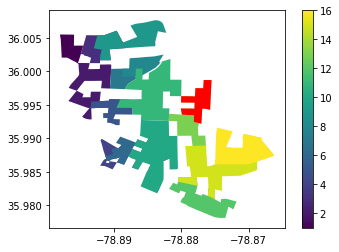

In [340]:
fig = gdf.plot('ids',legend=True)
gdf[gdf.ids==14].plot(ax=fig,color='red')

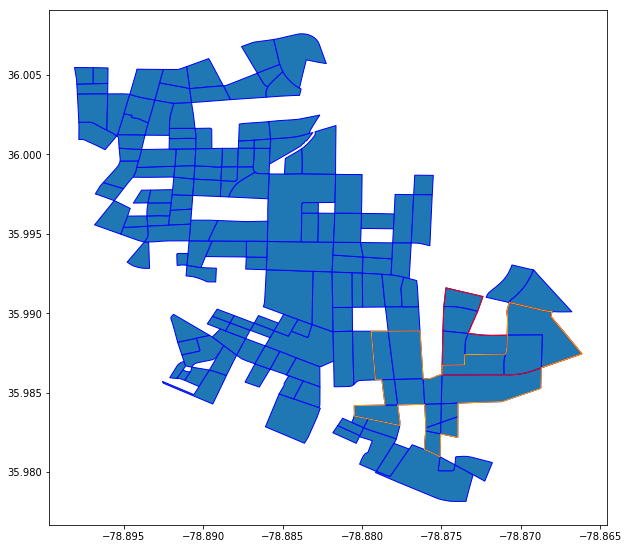

In [317]:
#fig = gdfBlksAll.plot(color='grey',figsize=(10,10))
fig = gdfBlksAll.plot(edgecolor='blue',figsize=(10,10))
gdf.loc[gdf.ids == 16].plot(ax=fig,color='',edgecolor='red')
gdf.loc[gdf.ids == 15].plot(ax=fig,color='',edgecolor='orange')


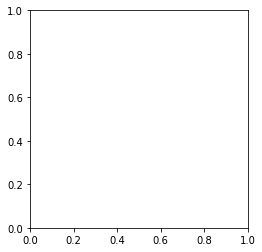

In [298]:
geomX = gdf.loc[gdf.ids == 16,'geometry']
fcSelect = gdfBlksAll[gdfBlksAll.geometry.centroid.within(geomX)]#.dissolve(by='ClusterID')
ax = fcSelect.plot(color='grey')
fcSelect.geometry.centroid.plot(ax=ax);
#gdf[gdf.ids == 16].plot(ax=fig,color='red')

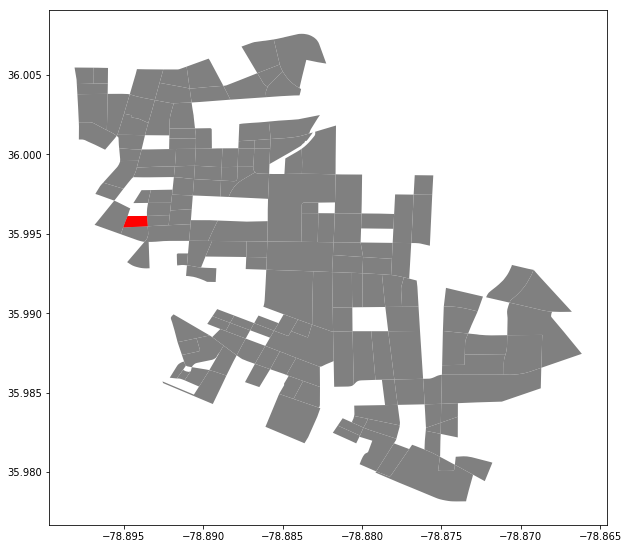

In [241]:
ax = gdfBlksAll.geometry.plot(color='grey',figsize=(10,10))
idx = 2
#gdf[gdf.ids == idx].plot(ax=ax,color='green')
#gdfBlksAll.geometry.centroid.plot(ax=ax)
ptS = gdf.loc[gdf.ids == idx,'geometry']
ptS = gdf[gdf.ids == idx]

gdfS = gdfBlksAll[(gdfBlksAll.intersects(ptS))]
gdfS.plot(ax=ax,color='red')
#ptS.plot(ax=ax,alpha=0.2);

In [266]:
df = pd.DataFrame({'ids':list(geomDict.keys())})
gdf = gpd.GeoDataFrame(df,geometry = list(geomDict.values()))
#gdf.to_file("../data/DURHAM/foo5.shp")
df

,ids,geometry
0,1,"POLYGON ((-78.89542 36.001236, -78.895455 36.0..."
1,2,"(POLYGON ((-78.893438 35.994492, -78.893379999..."
2,3,POLYGON ((-78.89366799999999 36.00121499999999...
3,4,"POLYGON ((-78.88961599999999 35.986417, -78.88..."
4,5,"POLYGON ((-78.890557 35.992277, -78.89062 35.9..."
5,6,"POLYGON ((-78.88736899999999 35.98566, -78.886..."
6,7,"POLYGON ((-78.888926 35.997347, -78.889438 35...."
7,8,"POLYGON ((-78.88584899999999 35.998776, -78.88..."
8,9,"POLYGON ((-78.890593 36.002301, -78.890519 36...."
9,10,"POLYGON ((-78.886082 35.982846, -78.885222 35...."


150
150
['370630002002018']
12
['370630002002021' '370630002002018' '370630002002017']
40
['370630002002021' '370630022001002' '370630022001001' '370630002002018'
 '370630002002017']
101
140


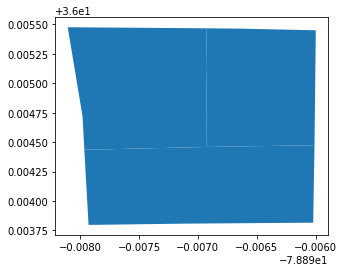

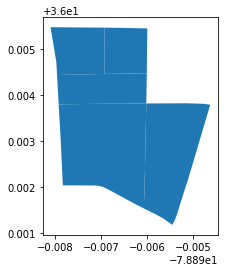

In [133]:
gdfSelect = (gdfBlksAll[(gdfBlksAll.geometry.intersects(geom)) & (gdfBlksAll.claimed == 0)]
             .reset_index()
             .dissolve(by='ClusterID', aggfunc='sum')
             .drop(['level_0','index','X'],axis=1)
            )
    #gdfSelect.plot()

gdfBlksAll.loc[gdfBlksAll.geometry.intersects(geom),'claimed'] = 1
print(gdfBlksAll.query('claimed == 0')['X'].count())

In [124]:
#Iterate through each clusterID
gdfs = []
for clusterID in clusterIDs:
    #print('\n',clusterID,end=":")
    #Get the blocks in the cluster
    gdfBlksAll = gdfMajBlack_LT50_2.query('ClusterID == {}'.format(clusterID)).reset_index()
    #Add the X coordinte to start from side of cluster
    gdfBlksAll['X'] = gdfBlksAll.geometry.centroid.x
    #Set value indicating no blocks have been examined
    gdfBlksAll['claimed'] = 0
    
    #Iterate until all block in the cluster have been examined
    orgIDx = clusterID     #Starting id for the output sub-cluster
    searchIter = 0 #Counter to avoid infinite loops
    #Compute the number of unclaimed blocks
    remainingBlocks = gdfBlksAll.query('claimed == 0')['X'].count()
    if remainingBlocks == 0:
        print("end",end="")
    
    #Iterate until all blocks have been claimed (or iteration count > 100)
    while remainingBlocks:
        searchIter += 1
        orgIDx += 1
        
        #Subset the unclaimed blocks in the cluster
        gdfBlks = gdfBlksAll[gdfBlksAll.claimed == 0].reset_index()
        
        #Get the eastern most block in the unclaimed block cluster, its BHH & geometry
        gdfNbrs = gdfBlks[gdfBlks.X == gdfBlks.X.min()]
        BHH = gdfNbrs.BlackHH.sum()
        geom = gdfNbrs.geometry.unary_union
        
        #Set that block as claimed in the master block set
        #gdfBlksAll.loc[gdfBlksAll.geometry.intersects(geom),'claimed'] = 1

        #Iterate while BHH <= 100 or until entire cluster has been searched
        iter_count = 0
        while BHH < 100:
            #Get the blocks that touch the current geometry
            gdfNbrs = gdfBlksAll[gdfBlksAll.geometry.intersects(geom)]
            #Compute the new aggregate BHH and Geometry
            BHH = gdfNbrs.BlackHH.sum()
            geom = gdfNbrs.geometry.unary_union
            #Increae the iter_count to catch infinite loops
            iter_count += 1
            if iter_count > 99: #Cannot reach BFF of 100; stop processing the cluster
                break

            
        #After 100 BHH are reached: select blocks intersecting the geom and assign an org unit ID
        gdfSelect = (gdfBlksAll[(gdfBlksAll.geometry.intersects(geom)) & (gdfBlksAll.claimed == 0)]
                     .reset_index()
                     .dissolve(by='ClusterID', aggfunc='sum')
                     .drop(['level_0','index','X'],axis=1)
                    )
        gdfSelect['OrgID'] = orgIDx
        
        #Set those blocks as claimed
        gdfBlksAll.loc[gdfBlksAll.geometry.intersects(geom),'claimed'] = 1
        
        #Compute the number of remaining blocks in the cluster
        remainingBlocks = gdfBlksAll.query('claimed == 0')['X'].count()
        #print(orgIDx,end=' ')
        
        #Add to the list
        gdfs.append(gdfSelect)
        
        if searchIter > 99:
            print("Infinite")
            break
    

In [128]:
clusterID = 5
gdfBlksAll = gdfMajBlack_LT50_2.query('ClusterID == {}'.format(clusterID)).reset_index()
gdfBlksAll['X'] = gdfBlksAll.geometry.centroid.x
gdfBlksAll['claimed'] = 0
print(gdfBlksAll.query('claimed == 0')['X'].count())

gdfBlks = gdfBlksAll[gdfBlksAll.claimed == 0].reset_index()
print(gdfBlks.query('claimed == 0')['X'].count())

gdfNbrs = gdfBlks[gdfBlks.X == gdfBlks.X.min()]; print(gdfNbrs.BLOCKID10.unique())
BHH = gdfNbrs.BlackHH.sum(); print(BHH)
geom = gdfNbrs.geometry.unary_union
#gdfNbrs.plot();

#Round 1
gdfNbrs = gdfBlksAll[gdfBlksAll.geometry.intersects(geom)]; print(gdfNbrs.BLOCKID10.unique())
BHH = gdfNbrs.BlackHH.sum(); print(BHH)
geom = gdfNbrs.geometry.unary_union
#gdfNbrs.plot();

#Round 3
gdfNbrs = gdfBlksAll[gdfBlksAll.geometry.intersects(geom)]; print(gdfNbrs.BLOCKID10.unique())
BHH = gdfNbrs.BlackHH.sum(); print(BHH)
geom = gdfNbrs.geometry.unary_union
#gdfNbrs.plot();

gdfSelect = (gdfBlksAll[(gdfBlksAll.geometry.intersects(geom)) & (gdfBlksAll.claimed == 0)]
             .reset_index()
             .dissolve(by='ClusterID', aggfunc='sum')
             .drop(['level_0','index','X'],axis=1)
            )
#gdfSelect.plot()

gdfBlksAll.loc[gdfBlksAll.geometry.intersects(geom),'claimed'] = 1
print(gdfBlksAll.query('claimed == 0')['X'].count())

150
150
['370630002002018']
12
['370630002002021' '370630002002018' '370630002002017']
40
['370630002002021' '370630022001002' '370630022001001' '370630002002018'
 '370630002002017']
101
140


In [40]:
gdf_Orgx = pd.concat(gdfs)
gdf_Org3 = gdf_Orgx.query('claimed > 0').reset_index()
gdf_Org3.shape

(49, 13)

In [125]:
gdf_Org3['PctBlack'] = gdf_Org3['P003003'] / gdf_Org3['P003001'] * 100
gdf_Org3['PctBlack18'] = gdf_Org3['P010004'] / gdf_Org3['P010001'] * 100
gdf_Org3.to_file('../data/Durham/Keep3.shp')

In [ ]:
#Assign a unique ID to each org unit
for i,df in enumerate(gdfs):
    df['OrgIDx'] = i
#Combine all together    
gdf_Org3 = pd.concat(gdfs).reset_index()
#gdf_Org3 = gdfsClaimed.dissolve(by='OrgIDx',aggfunc='sum')

#Combine each cluster into a single dataframe and write to a file
#gdf_Org3 = pd.concat(gdfs).reset_index()
gdf_Org3['OrgID'] = gdf_Org2['OrgID'].max() + gdf_Org3.index + 1
gdf_Org3['OrgType'] = 'Partial block cluster'
gdf_Org3.to_file('../data/Durham/Keep3.shp')

In [ ]:
#Merge all three keepers
gdfAllOrgs = pd.concat((gdf_Org1, gdf_Org2, gdf_Org3),axis=0,sort=True)
gdfAllOrgs.to_file('../data/DURHAM/Orgs.shp')